In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from gemlib.distributions import DiscreteTimeStateTransitionModel
from gemlib.mcmc import adaptive_hmc, make_initial_running_variance
from gemlib.mcmc import mcmc, multi_scan, MwgStep
from gemlib.mcmc.discrete_time_state_transition_model import move_events, right_censored_events_mh
from tensorflow_probability.python.internal import unnest

tfd = tfp.distributions
tfm = tfp.mcmc

%matplotlib inline

2025-02-17 15:36:07.542162: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 15:36:07.672704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 15:36:07.734988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 15:36:07.735396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 15:36:07.816978: I tensorflow/core/platform/cpu_feature_gua

## Load covariate data in

In [2]:
def load_connectivity(filename):
    return (
        pd.read_csv(
            filename,
            index_col="Neo",
        )
        .sort_index()
        .sort_index(
            axis=1,
        )
    )


def load_day_of_admission(filename):
    return pd.read_csv(filename, index_col="neoid").sort_index()


def load_and_centre_neonate_covars(filename):
    covars = pd.read_csv(filename, index_col="neoid").sort_index()
    covars -= covars.mean(axis=0)
    return covars


def load_and_centre_maternal_covars(filename):
    covars = pd.read_csv(filename, index_col="pid")
    covars.index = covars.index.astype("str")
    covars = covars - covars.mean(axis=0)
    return covars.sort_index()


def load_initial_state(filename):
    is_colonised = pd.read_csv(filename, index_col="pid").sort_index()
    is_colonised = pd.concat(
        [
            is_colonised[is_colonised.index.str.contains("^[A-Z]")],
            is_colonised[is_colonised.index.str.contains("^[0-9]")],
        ],
        axis=0,
    )
    expanded_form = pd.concat(
        [
            1 - is_colonised.iloc[:, 0],
            is_colonised.iloc[:, 0],
        ],
        axis="columns",
    )
    expanded_form.columns = ["U", "C"]
    return expanded_form


def load_test_results(neonate_filename, mothers_filename):

    neonates = pd.read_csv(neonate_filename, index_col="neoid").sort_index()
    mothers = pd.read_csv(mothers_filename, index_col="pid")
    mothers.index = mothers.index.astype("str")
    mothers = mothers.sort_index()

    df = pd.concat(
        [
            neonates[["interval_end", "status_end"]],
            mothers[["interval_end", "status_end"]],
        ],
        axis="index",
    )

    unique_ids = df.index.astype("str").unique()
    unique_iloc = pd.Series(
        np.arange(unique_ids.shape[0]), index=unique_ids, name="iid"
    )
    df = df.merge(unique_iloc, how="left", left_index=True, right_index=True)
    df = pd.concat(
        [
            df[df.index.str.contains("^[A-Z]")],
            df[df.index.str.contains("^[0-9]")],
        ],
        axis="index",
    )
    df = df[["iid", "interval_end", "status_end"]]
    df.columns = ["iid", "test_day", "test_status"]
    df["test_day"] = df["test_day"].astype("int32", errors="ignore")

    # Strip out NaN rows
    df = df[~df.isna().any(axis=1)]

    return df

In [3]:
# Assemble data
max_time_window = 30

observed_data = load_test_results(
    "data/neo_state_changes.csv", "data/mat_state_changes.csv"
)

constant_data = dict(
    connectivity=load_connectivity("data/conn_matrix_gem.csv"),
    day_of_admission=load_day_of_admission("data/neo_adm.csv"),
    covars_neo=load_and_centre_neonate_covars("data/neo_cov.csv")[
        [
            "matabxall",
            "neoabx",
            "intabx",
            "gestage",
            "outborn",
            "sex",
            "dlivmod",
            "mathiv",
            "wt",
            "o2",
            "notbreast",
        ]
    ],
    covars_mother=load_and_centre_maternal_covars("data/mat_cov.csv"),
    observation_coords=observed_data[["test_day", "iid"]],
)
constant_data["num_babies"] = constant_data["covars_neo"].shape[0]
constant_data["num_mothers"] = constant_data["covars_mother"].shape[0]

initial_state = load_initial_state("data/init_state.csv")

In [4]:
print("Neonate covariates:", constant_data["covars_neo"].columns)
print("Mother covariates:", constant_data["covars_mother"].columns)

Neonate covariates: Index(['matabxall', 'neoabx', 'intabx', 'gestage', 'outborn', 'sex', 'dlivmod',
       'mathiv', 'wt', 'o2', 'notbreast'],
      dtype='object')
Mother covariates: Index(['mathiv', 'matabx', 'houseno', 'anc_hosp'], dtype='object')


## Exploration of missing data

First create some matrix plots to show where the missing data is.

Text(0.5, 1.0, 'Neonate covariates')

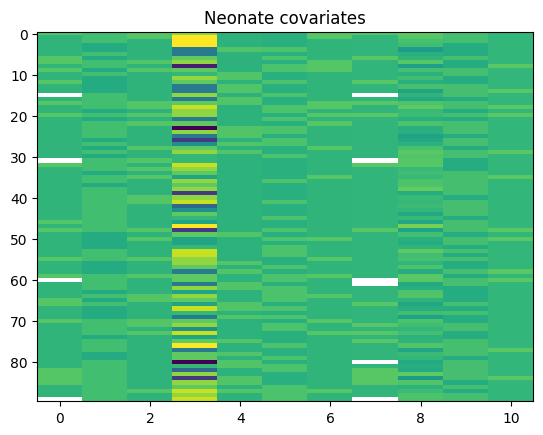

In [5]:
plt.imshow(constant_data["covars_neo"], aspect="auto")
plt.title("Neonate covariates")

Text(0.5, 1.0, 'Mother covariates')

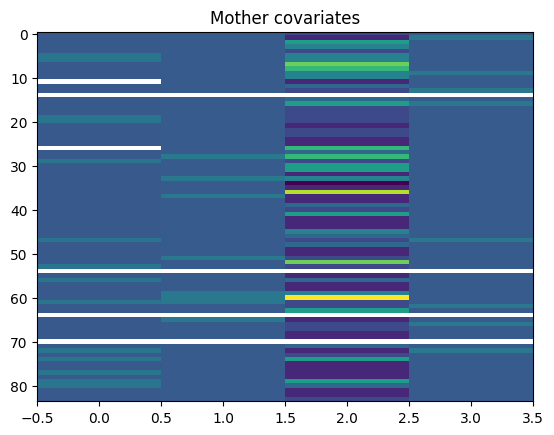

In [6]:
plt.imshow(constant_data["covars_mother"], aspect="auto")
plt.title("Mother covariates")

We conclude the amount of missing data is relatively small, so proceed by replacing it with 0.

* For the mother's initial status, we assume this is uncolonised.
* For the covariates, remember that we have centred all the covariates above, so 0 is in fact the mean value.

In [7]:
initial_state[initial_state.isna()] = 0.0
for v in ["covars_neo", "covars_mother", "day_of_admission"]:
    constant_data[v][constant_data[v].isna()] = 0.0

### Connectivity matrix

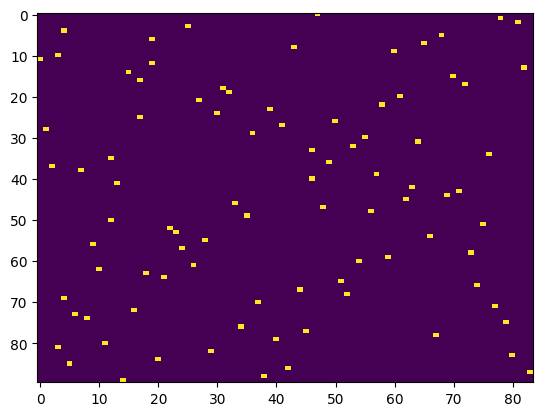

In [8]:
# Ensure each baby has one mother
assert np.all(constant_data["connectivity"].sum(axis=1) == 1)

# Plot the connectivity
plt.imshow(constant_data["connectivity"], aspect="auto")

# Model definition

We assume that babies and mothers are in separate populations, but that both undergo a U->C transition, i.e. uncolonised to colonised.  

The first step is to characterise this state transition process as a incidence matrix

In [9]:
DTYPE = np.float64

Now we need to set up some population data, such as a the initial state `[U(0), C(0)]`.  
`DiscreteStateTimeTransitionModel` demands a storage order of `[M, S]` for `M` individuals and `S` states.

# Full joint probability model

In [10]:
incidence_matrix = np.array([[-1], # U |
                             [1]], # C
                            dtype=DTYPE)

def build_model(covariates, initial_state):

    # Constants
    SENSITIVITY = 0.90
    SPECIFICITY = 0.99

    # Covariates
    connectivity = tf.convert_to_tensor(covariates["connectivity"], dtype=DTYPE)
    day_of_admission = tf.convert_to_tensor(
        covariates["day_of_admission"].to_numpy().flatten(), dtype=DTYPE
    )
    covars_neo = tf.convert_to_tensor(covariates["covars_neo"], dtype=DTYPE)
    covars_mother = tf.convert_to_tensor(covariates["covars_mother"], dtype=DTYPE)

    observation_coords = tf.convert_to_tensor(
        covariates["observation_coords"], dtype=tf.int32
    )

    num_individuals = covariates["num_babies"] + covariates["num_mothers"]

    initial_state = tf.convert_to_tensor(initial_state.to_numpy().astype(DTYPE))

    def model_definition():
        # Priors
        alpha_0 = yield tfd.Normal(
            loc=tf.constant(np.log(0.1), DTYPE),
            scale=tf.constant(10.0, DTYPE),
            name="alpha_0",
        )
        alpha_1 = yield tfd.Normal(
            loc=tf.constant(np.log(0.1), DTYPE),
            scale=tf.constant(10.0, DTYPE),
            name="alpha_1",
        )
        alpha_mum = yield tfd.Normal(
            loc=tf.constant(np.log(0.1), DTYPE),
            scale=tf.constant(10.0, DTYPE),
            name="alpha_mum",
        )
        phi = yield tfd.Gamma(
            concentration=tf.constant(2.0, DTYPE),
            rate=tf.constant(1.0, DTYPE),
            name="phi",
        )
        beta_neo = yield tfd.Independent(
            tfd.Normal(
                loc=tf.zeros(covars_neo.shape[-1], dtype=DTYPE),
                scale=tf.constant(1.0, DTYPE),
            ),
            reinterpreted_batch_ndims=1,
            name="beta_neo",
        )
        beta_mother = yield tfd.Independent(
            tfd.Normal(
                loc=tf.zeros(covars_mother.shape[-1], dtype=DTYPE),
                scale=tf.constant(1.0, DTYPE),
            ),
            reinterpreted_batch_ndims=1,
            name="beta_mother",
        )

        # UC model
        def transition_rate_fn(t, state):
            is_in_ward = tf.cast(t >= day_of_admission, dtype=DTYPE)
            alpha_t = alpha_0 + is_in_ward * alpha_1

            indices = tf.stack(
                [
                    tf.range(covariates["num_babies"], num_individuals),
                    tf.ones([covariates["num_mothers"]], dtype=tf.int32),
                ],
                axis=-1,
            )
            colonised_mums = tf.gather_nd(state, indices)
            uc_rate_baby = tf.math.exp(
                alpha_t + tf.linalg.matvec(covars_neo, beta_neo)
            ) * (1 + phi * tf.linalg.matvec(connectivity, colonised_mums))

            uc_rate_mother = tf.math.exp(
                alpha_mum + tf.linalg.matvec(covars_mother, beta_mother)
            )

            all_rates = tf.concat([uc_rate_baby, uc_rate_mother], axis=0)
            return (all_rates,)

        #                             U->C

        uc_model = DiscreteTimeStateTransitionModel(
            transition_rate_fn=transition_rate_fn,
            initial_state=initial_state,
            time_delta=1.0,
            initial_step=0,
            num_steps=16,
            incidence_matrix=incidence_matrix,
            name="uc_events",
        )
        
        uc_events = yield uc_model

        # uc_model emit a data structure of shape [N, T, 1] from which
        # we calculate the state tensor
        modelled_state = uc_model.compute_state(uc_events)

        # Modelled state is [N, T, 2] for each of U and C
        # We gather entries in modelled state according to the timepoints we observe.
        required_indices = tf.concat(
            [
                observation_coords,
                tf.fill([observation_coords.shape[0], 1], 1),
            ],
            axis=-1,
        )
        modelled_positive_tests = tf.gather_nd(modelled_state, indices=required_indices)

        # Bernoulli sampling for observation process
        # Pr(T+) = Pr(T+ | D+) + Pr(T+ | D-) = Se*D+ + (1-Sp)*(1-D+)
        # Pr(T-) = Pr(T- | D-) + Pr(T- | D+) = Sp*(1-D+) + (1-Se)*D+
        prob_test_pos = SENSITIVITY * modelled_positive_tests + (1.0 - SPECIFICITY) * (
            1 - modelled_positive_tests
        )
        y = yield tfd.Independent(
            tfd.Bernoulli(
                probs=prob_test_pos,
                dtype=DTYPE,
            ),
            reinterpreted_batch_ndims=1,
            name="observations",
        )

    return tfd.JointDistributionCoroutine(model_definition)

In [11]:
joint_model = build_model(
    covariates=constant_data,
    initial_state=initial_state,
)

2025-02-17 15:36:14.855820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-17 15:36:14.995900: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Test the model

Here we take a draw from the unconditioned prior model, and make sure we get finite values for
the log posterior density.

In [12]:
model_dists, sim = joint_model.sample_distributions(
        seed=(0, 0),
        alpha_1=np.log(1.0),
        alpha_0=np.log(0.1),
        alpha_mum=np.log(0.01),
        beta_neo=tf.zeros(11, dtype=np.float64),
        beta_mother=tf.zeros(4, dtype=np.float64),
    )

In [13]:
joint_model.log_prob(sim)

<tf.Tensor: shape=(), dtype=float64, numpy=-386.79593919815295>

Visualise the observed data from the simulated model

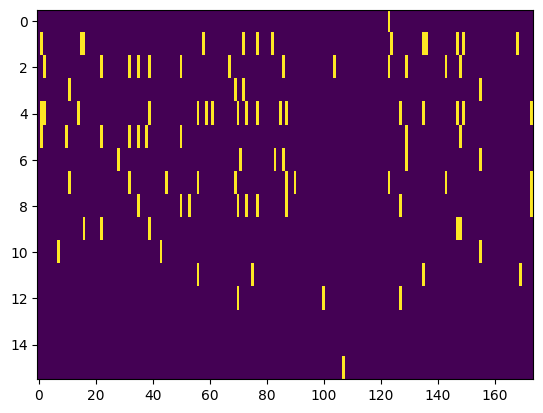

In [14]:
%matplotlib inline
obs_matrix = tf.scatter_nd(
    indices=constant_data["observation_coords"],
    updates=sim.observations,
    shape=tf.shape(
        sim.uc_events[..., 0],
    ),
)

plt.imshow(
    obs_matrix.numpy().astype("bool"),
    aspect="auto",
    interpolation="none",
)

Visualise the underlying state transition events

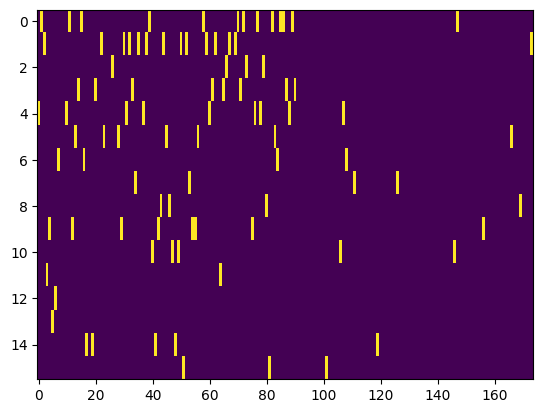

In [15]:
plt.imshow(
    sim.uc_events[..., 0],
    aspect="auto",
    interpolation="none",
)

We also check that we get a finite value of the log posterior with the observed data. This
will help us to start off the MCMC chain below.

In [16]:
sim_with_actual_obs = sim._replace(observations=observed_data["test_status"].to_numpy())
joint_model.log_prob(sim_with_actual_obs)

<tf.Tensor: shape=(), dtype=float64, numpy=-755.388574540736>

## Build MCMC algorithm

The first step is to assemble a conditional log probability mode, where we condition on 
the observed data to get the posterior distribution
$$
\pi(\theta, X | Y)
$$
where $\theta$ are the parameters, $X$ is the censored event times, and $Y$ is the observed data. 

In [17]:
# conditioned_model = joint_model.experimental_pin(
#     observations=observed_data["test_status"].to_numpy()
# )
conditioned_model = joint_model.experimental_pin(
    observations=observed_data["test_status"].to_numpy()
)

Now construct a "chain state", i.e. the starting values for all the parameters and missing data.
We'll manually set the parameters, but take the missing data from the simulation above.

In [18]:
initial_chain_state = conditioned_model.sample_unpinned(seed=(0, 1))
# initial_chain_state = initial_chain_state._replace(
#     alpha_0=tf.constant(-1.5, DTYPE),
#     alpha_1=tf.constant(0.0, DTYPE),
#     alpha_mum=tf.constant(-1.5, DTYPE),
#     phi=tf.constant(0.4, DTYPE),
#     beta_neo=tf.zeros(constant_data["covars_neo"].shape[-1], dtype=DTYPE),
#     beta_mother=tf.zeros(constant_data["covars_mother"].shape[-1], dtype=DTYPE),
#     uc_events=sim.uc_events,
# )

### MCMC Algorithm

The code below builds the following MCMC algorithm:

In [36]:
param_names = (
        "alpha_0", "alpha_1", "alpha_mum", "phi", "beta_neo", "beta_mother"
)
param_hmc = MwgStep(
    adaptive_hmc(
        initial_step_size=0.1,
        num_leapfrog_steps=16,
        num_step_size_adaptation_steps=1000,
        num_mass_matrix_estimation_steps=900,
        initial_running_variance=make_initial_running_variance(
            position=tuple(getattr(initial_chain_state, a) for a in param_names),
        ),
    ),
    target_names=param_names,
)

move_events_kernel = MwgStep(
    move_events(
        incidence_matrix=incidence_matrix,
        transition_index=0,
        num_units=2,
        delta_max=10,
        count_max=1,
    ),
    target_names="uc_events",
    kernel_kwargs_fn=lambda _: {"initial_conditions": initial_state},
)


censored_events_kernel = MwgStep(
    right_censored_events_mh(
        incidence_matrix=incidence_matrix,
        transition_index=0,
        count_max=1,
        t_range=[9, 16],
    ),
    target_names="uc_events",
    kernel_kwargs_fn=lambda _: {"initial_conditions": initial_state},
)

# Compound algorithm:
# 1. Update parameters,
# 2. For z in 1:20 do:
#    a. move events
#    b. add/delete an event
algorithm = param_hmc >> multi_scan(
     20, move_events_kernel >> censored_events_kernel
)

In [37]:
@tf.function(jit_compile=True)
def run_mcmc(num_samples=20000, seed=[0,0]):
    return mcmc(
        num_samples=num_samples,
        sampling_algorithm=algorithm,
        target_density_fn=conditioned_model.log_prob,
        initial_position=initial_chain_state,
        seed=seed,
    )

samples, info = run_mcmc()

In [39]:
print(
    "HMC acceptance:",
    np.mean(unnest.get_innermost(info[0], "is_accepted")),
)
print("Move events:", np.mean(info[1].last_results[0].is_accepted))
print(
    "Add/delete events:", np.mean(info[1].last_results[1].is_accepted)
)

HMC acceptance: 0.8654
Move events: 0.1678
Add/delete events: 0.1318


## Examine MCMC output

Here the "traceplots" (left hand column below) should look like "furry caterpillars", indicating that there is no systematic drift left to right, and that the MCMC is randomly moving about some mean (the posterior mean).  The kernel density estimates show the actual posterior distribution obtained from the MCMC samples, and should look close to a Normal distribution (though skewness is okay!).

In [40]:
def traceplots(
    samples,
    burnin=0,
    params=None,
):

    if params is None:
        params = samples._fields

    samples = {k: getattr(samples, k)[burnin:] for k in params}
    fig, axs = plt.subplots(len(samples), 2, figsize=(10, 5 * len(samples)))

    for trace, kde, (k, x) in zip(axs[:, 0], axs[:, 1], samples.items()):
        trace.plot(x)
        trace.set_ylabel(k)
        parm_names = params[k].values() if isinstance(params[k], dict) else [params[k]]
        df = pd.DataFrame(x, columns=parm_names)
        sns.kdeplot(data=df, ax=kde)
        kde.set_xlabel(k)

    return fig, axs

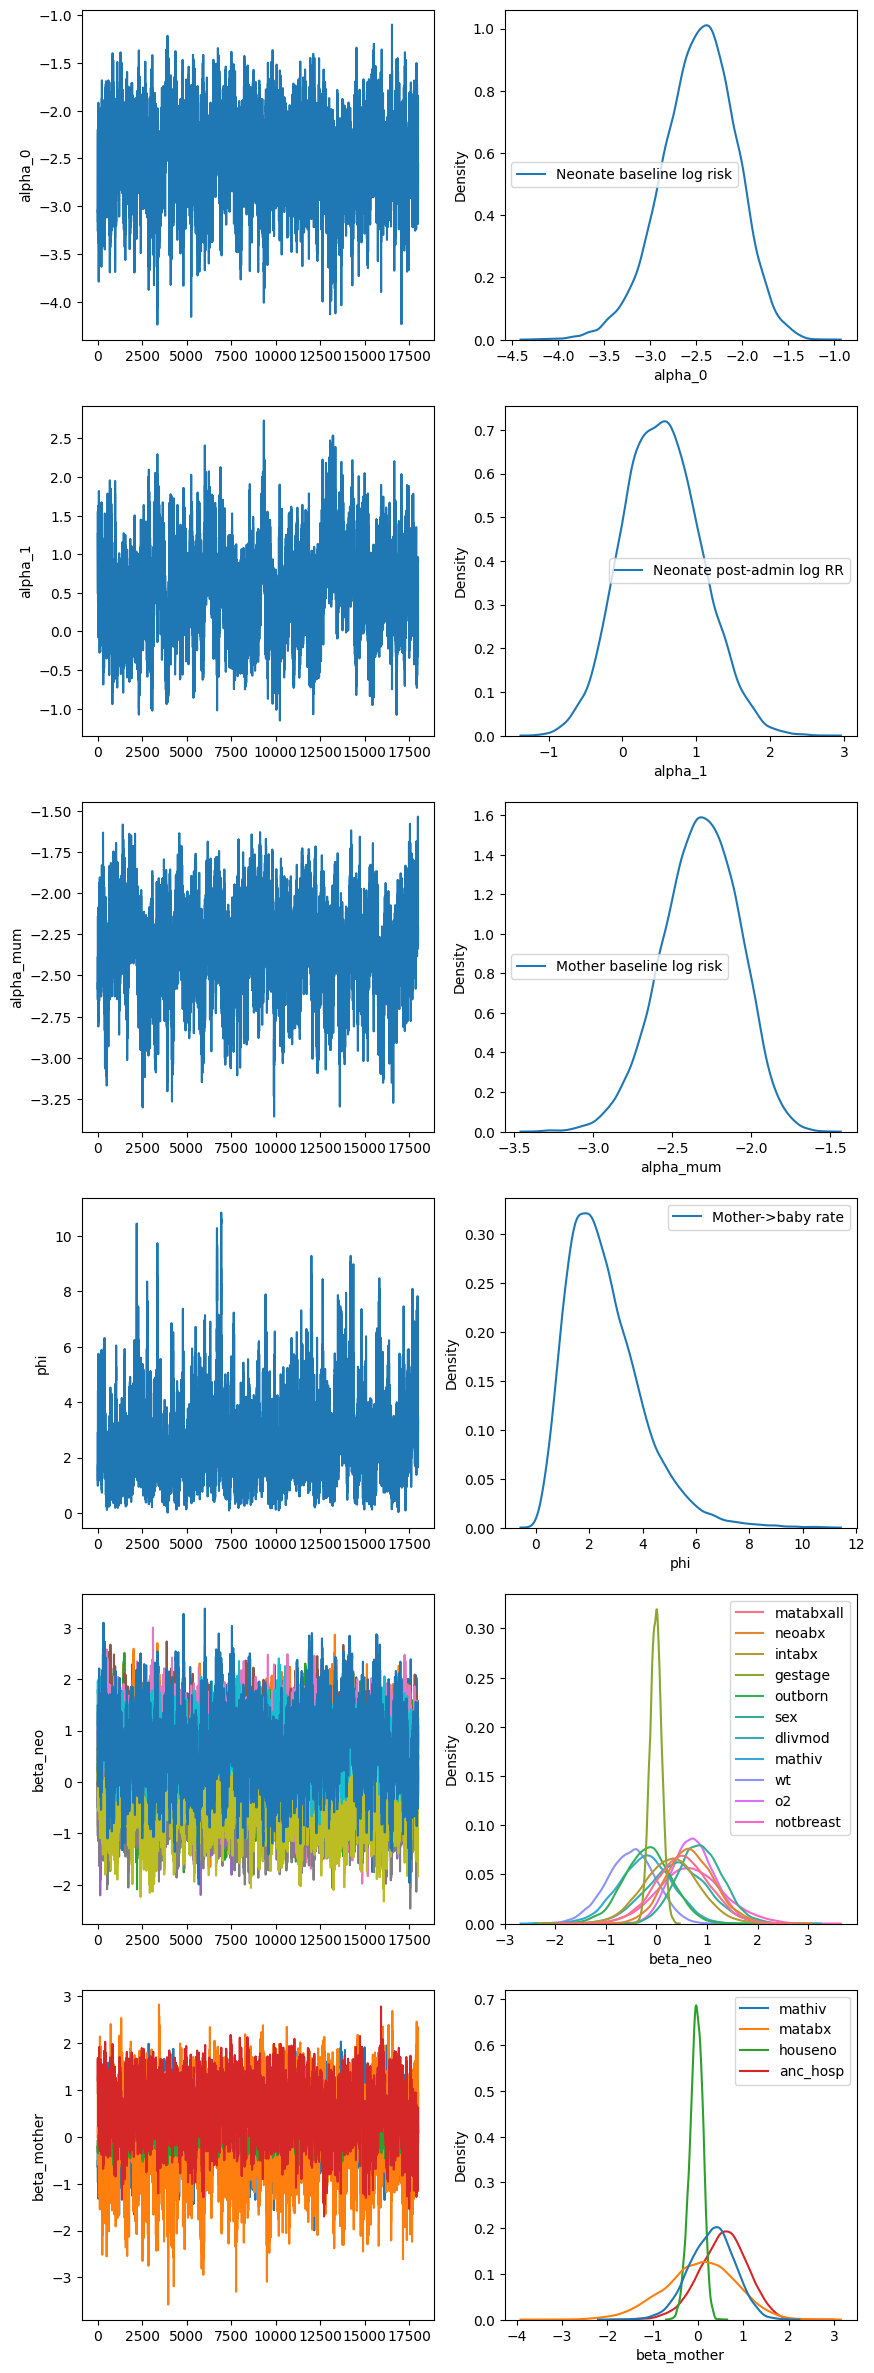

In [41]:
_ = traceplots(
    samples,
    burnin=2000,
    params=dict(
        alpha_0=r"Neonate baseline log risk",
        alpha_1=r"Neonate post-admin log RR",
        alpha_mum=r"Mother baseline log risk",
        phi=r"Mother->baby rate",
        beta_neo=constant_data["covars_neo"].columns,
        beta_mother=constant_data["covars_mother"].columns,
    ),
)

## Summary tables

We provide quick summary tables of the above distributions, for easy reading.

In [42]:
def summarise(samples, varnames):
    means = tf.reduce_mean(samples, axis=0)
    percentiles = tfp.stats.percentile(samples, q=(2.5, 97.5), axis=0).numpy()

    df = pd.DataFrame({"2.5%": percentiles[0], "mean": means, "97.5%": percentiles[1]})
    df.index = pd.Index(varnames)
    return df


summarise(samples.beta_neo[2000:], varnames=constant_data["covars_neo"].columns)

2.5%      mean     97.5%
matabxall -0.537047  0.514365  1.576114
neoabx    -0.256289  0.672402  1.672259
intabx    -0.775832  0.294604  1.384884
gestage   -0.231046 -0.009935  0.215853
outborn   -1.136414 -0.169535  0.752046
sex        0.003889  0.863616  1.764653
dlivmod   -0.758666  0.411076  1.599751
mathiv    -1.280030 -0.214897  0.802274
wt        -1.474688 -0.504201  0.402191
o2        -0.056787  0.728158  1.577993
notbreast -0.585776  0.678215  2.018920

In [43]:
summarise(samples.beta_mother[2000:], varnames=constant_data["covars_mother"].columns)

2.5%      mean     97.5%
mathiv   -0.693670  0.306088  1.234196
matabx   -1.611625  0.035649  1.494592
houseno  -0.346665 -0.040217  0.226691
anc_hosp -0.539694  0.558602  1.530447

## Plot the posterior of the colonisation states

We plot the posterior probability that each individual is in the Colonised state at each timepoint.  This is in the form of a coloured matrix, onto which we plot the observed testing data as well as the day of admission relative to birth date.

In [44]:
def plot_uc_events(samples, ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    uc_mean = tf.reduce_mean(samples, axis=0)
    img = ax.imshow(np.transpose(uc_mean), aspect="auto", cmap="viridis", interpolation="none")
    plt.colorbar(img)

    return ax


colonisation_status = model_dists.uc_events.compute_state(samples.uc_events[2000:])

Text(0, 0.5, 'Individual')

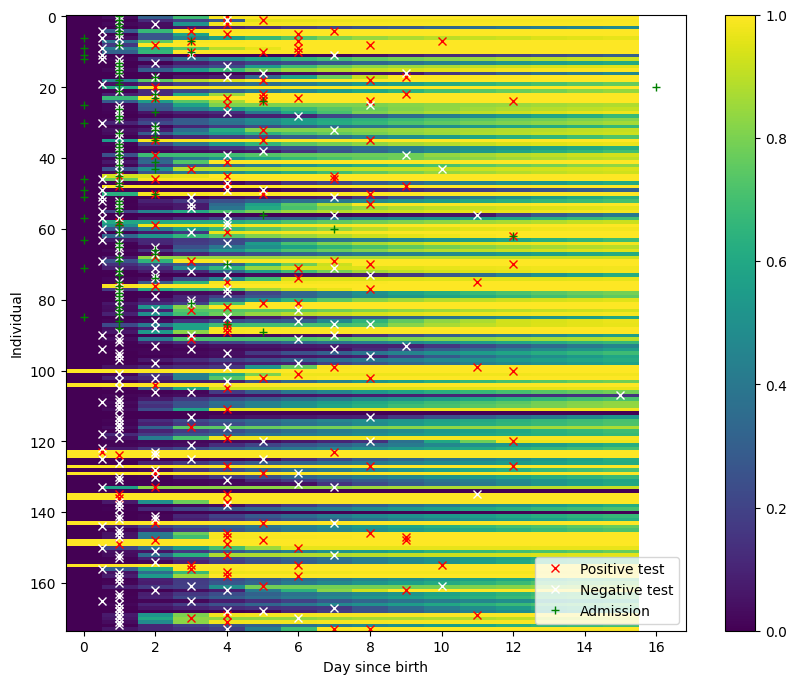

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
_ = plot_uc_events(colonisation_status[..., 1], ax=ax)

positives = observed_data[observed_data["test_status"] == 1.0]
negatives = observed_data[observed_data["test_status"] != 1.0]

plt.plot(
    positives["test_day"], positives["iid"], "x", color="red", label="Positive test"
)
plt.plot(
    negatives["test_day"], negatives["iid"], "x", color="white", label="Negative test"
)

plt.plot(
    constant_data["day_of_admission"],
    np.arange(constant_data["day_of_admission"].shape[0]),
    "+",
    color="green",
    label="Admission",
)
plt.legend()
plt.xlabel("Day since birth")
plt.ylabel("Individual")